In [1]:
#   bem: triangulation and fmm/bem electrostatics tools 
#
#   Copyright (C) 2011-2012 Robert Jordens <jordens@gmail.com>
#
#   This program is free software: you can redistribute it and/or modify
#   it under the terms of the GNU General Public License as published by
#   the Free Software Foundation, either version 3 of the License, or
#   (at your option) any later version.
#
#   This program is distributed in the hope that it will be useful,
#   but WITHOUT ANY WARRANTY; without even the implied warranty of
#   MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
#   GNU General Public License for more details.
#
#   You should have received a copy of the GNU General Public License
#   along with this program.  If not, see <http://www.gnu.org/licenses/>.

# `bem` 3D electrostatics example

In [13]:
import logging, os
import numpy as np
import matplotlib.pyplot as plt

from bem import Electrodes, Sphere, Mesh, Grid, Configuration, Result
from bem.formats import stl

In [2]:
# base file name for outputs and inputs is the script name
try:
    # works only if we are a script
    prefix = os.path.splitext(__file__)[0]
except NameError:
    # fallback for notebooks
    prefix = "SimpleTrap"

In [3]:
# scale to natural units (ion height)
scale = 40e-6
use_stl = True

if not use_stl:
    # load electrode faces from loops
    ele = Electrodes.from_trap(open("%s.ele" % prefix), scale)
    # initial triangulation, area 20, quiet
    mesh = Mesh.from_electrodes(ele)
    mesh.triangulate(opts="qa10Q")
else:
    # load electrode faces from colored stl
    s = stl.read_stl(open("%s.stl" % prefix, "rb"))
    mesh = Mesh.from_mesh(stl.stl_to_mesh(*s, scale=scale/1e-6,
        rename={9495: "DC1", 17962: "DC3", 18994: "DC5",
        18869: "DC2", 20943: "RF", 18129: "DC4"}))

dropping 0


In [4]:
def run_job(args):
    job, grid, prefix = args
    # refine twice adaptively with increasing number of triangles, min
    # angle 25deg
    job.adapt_mesh(triangles=4e2, opts="q25Q")
    job.adapt_mesh(triangles=1e3, opts="q25Q")
    # solve for charges
    job.solve_singularities(num_lev=3)
    # get potentials and fields
    result = job.simulate(grid, field=job.name=="RF", num_lev=1)
    result.to_vtk(prefix)
    print "finished job %s" % job.name
    return job.collect_charges()

In [5]:
# set .1 max area within 3
mesh.areas_from_constraints(Sphere(center=np.array([0, 0, 1.]),
           radius=2, inside=.2, outside=10.))
# retriangulate quality and quiet with areas
mesh.triangulate(opts="qQ", new=False)
# save base mesh to vtk
mesh.to_vtk(prefix)
# grid to evalute potential and fields at
n, s = 2*10, .1
grid = Grid(center=(0, 0, 1.5), step=(s, s, s), shape=(n, n, n))
# generate electrode potential configurations to simulate
# use regexps to match electrode names
jobs = list(Configuration.select(mesh, "DC.*", "RF"))
# run the different electrodes on the parallel pool
#pmap = Pool().map # parallel map
pmap = map # serial map
pmap(run_job, ((job, grid, prefix) for job in jobs))

finished job DC1
finished job DC3
finished job DC5
finished job DC2
finished job RF
finished job DC4


[array([ 4.015966  , -0.94848454, -0.24906277, -0.07080647, -1.62394951,
        -0.12604093]),
 array([-0.90960094,  3.77296251, -0.07091635, -1.05589966, -0.4002636 ,
        -0.92416197]),
 array([-0.23048589, -0.06929706,  5.2529352 , -0.01437012, -4.38615935,
        -0.22866961]),
 array([-0.06896146, -1.10779123, -0.01434482,  1.40502098, -0.06110635,
        -0.06933333]),
 array([ -1.43547759,  -0.39233336,  -4.35984025,  -0.06154495,
         10.41131813,  -1.44504742]),
 array([-0.12591326, -0.9487168 , -0.24696988, -0.07081001, -1.6260726 ,
         4.01319566])]

<matplotlib.contour.QuadContourSet instance at 0x7f04bc31c2d8>

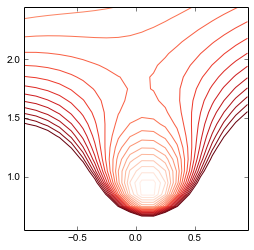

In [6]:
# isocontour plot of the RF pseudopotential radially
result = Result.from_vtk(prefix, "RF")
p = result.pseudo_potential
x = grid.to_mgrid()[:, p.shape[0]/2]
p = p[p.shape[0]/2]
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(x[1], x[2], p, levels=np.linspace(0, 2e-2, 20), cmap=plt.cm.Reds)

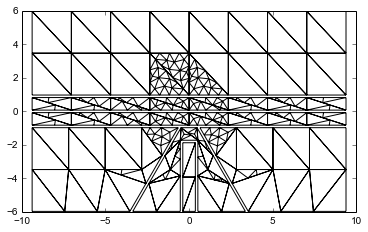

In [7]:
fig, ax = plt.subplots(subplot_kw=dict(aspect="equal"))
mesh.plot(ax)

In [8]:
# explore it in fancy 3D
# fire up a mayavi2 window showing base mesh, charges on final mesh
# and isosurfaces of the pseudopotential
Result.view(prefix, "RF")
# need to start the full eventloop for the window.
# close it to return control to the notebook
from pyface.api import GUI
GUI().start_event_loop()

In [10]:
from electrode import System, GridElectrode

# load the electrostatics results into a electrode.System()
s = System()
for name in "DC1 DC2 DC3 DC4 DC5 RF".split():
    r = Result.from_vtk(prefix, name)
    e = GridElectrode.from_result(r)
    e.name = name
    s.append(e)
s["RF"].rf = 1.

In [11]:
from scipy.constants import atomic_mass
x0 = s.minimum((0, 0, 1.))
for _ in s.analyze_static(x0, m=25*atomic_mass, u=50.,
                          l=40e-6, o=100e6*2*np.pi):
    print _

params: u=50 V, f=100 MHz, m=25 amu, q=1 qe, l=40 µm, scale=3.82 eV
corrdinates:
 analyze point: [ -1.28966195e-04   1.00054172e-01   8.96928538e-01]
               ([ -5.15864781e-03   4.00216690e+00   3.58771415e+01] µm)
 minimum is at offset: [ 0.  0.  0.]
                      ([ 0.  0.  0.] µm)
potential:
 dc electrical: 0 (0 eV)
 rf pseudo: 6.3e-08 (2.4e-07 eV)
 saddle offset: [ -2.05386105e+00  -3.36504008e-04  -2.07128856e-03]
               ([ -8.21544419e+01  -1.34601603e-02  -8.28515426e-02] µm)
 saddle height: 2.4e-07 (9.3e-07 eV)
force:
 dc electrical: [ 0.  0.  0.]
               ([ 0.  0.  0.] eV/m)
 rf pseudo: [ -8.50310486e-08  -2.91724120e-08  -1.29751233e-09]
           ([-0.00811781 -0.00278506 -0.00012387] eV/m)
modes:
 pp+dc normal curvatures: [ -6.06520753e-07   2.86678373e-01   2.86935626e-01]
 motion is bounded: True
 pseudopotential modes:
  a: nan MHz, [ 0.99999654  0.00239921  0.00107489]
  b: 8.179 MHz, [ -5.11749963e-04   5.78681244e-01  -8.15553650e-01]
 

/home/rjordens/work/nist/electrode/electrode/system.py:894: RuntimeWarning: invalid value encountered in sqrt
  freqs_pp = (scale*curves/l**2/m)**.5/(2*np.pi)


<matplotlib.contour.QuadContourSet instance at 0x7f049c5dc368>

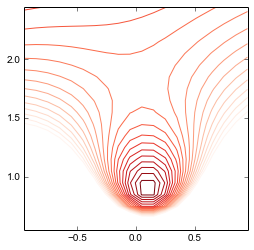

In [12]:
n = 30
#xyz = np.mgrid[-.1:.1:1j*n, -.1:.1:1j*n, 1.12:2]
#xyz = np.mgrid[0:1, -.02:.02:1j*n, .5:1.5:1j*n]
xyz = grid.to_mgrid()
p = s.potential(xyz.reshape(3, -1).T, 0).reshape(xyz[0].shape)
v = np.linspace(0, 2e-2, 21)
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.contour(xyz[1, 10, :, :], xyz[2, 10, :, :], p[10, :, :], v, cmap=plt.cm.Reds_r)